In [42]:
#Data Analysis
import numpy as np
import pandas as pd

#Plotting
import matplotlib.pyplot as plt

#LSTM
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils

#Utils
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [45]:
device

device(type='cpu')

In [46]:
DATA_URL = 'https://robjhyndman.com/data/hier1_with_names.csv'

In [47]:
data = pd.read_csv(DATA_URL)

In [48]:
data.sample(5)

,Total,Hol,VFR,Bus,Oth,NSW - hol,VIC - hol,QLD - hol,SA - hol,WA - hol,...,QLD - oth - city,QLD - oth - noncity,SA - oth - city,SA - oth - noncity,WA - oth - city,WA - oth - noncity,TAS - oth - city,TAS - oth - noncity,NT - oth - city,NT - oth - noncity
24,85852,42091,30568,9522,3671,13353,9601,8990,3210,4316,...,460,268,181,187,353,190,101,98,29,12
29,59637,26719,19635,9161,4122,7812,4855,7551,2047,2887,...,499,640,215,109,326,250,31,49,91,39
33,67523,30777,22948,10099,3699,9489,5489,7953,2373,2862,...,469,316,239,195,193,234,84,85,29,52
17,63529,28899,20576,10418,3636,9472,5400,7323,2109,2848,...,422,309,334,156,201,179,73,18,40,55
27,70217,29070,24212,10266,6669,8738,5145,9073,1875,2870,...,696,847,378,327,442,823,66,32,139,144


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 89 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Total                36 non-null     int64
 1   Hol                  36 non-null     int64
 2   VFR                  36 non-null     int64
 3   Bus                  36 non-null     int64
 4   Oth                  36 non-null     int64
 5   NSW - hol            36 non-null     int64
 6   VIC - hol            36 non-null     int64
 7   QLD - hol            36 non-null     int64
 8   SA - hol             36 non-null     int64
 9   WA - hol             36 non-null     int64
 10  TAS - hol            36 non-null     int64
 11  NT - hol             36 non-null     int64
 12  NSW - vfr            36 non-null     int64
 13  VIC - vfr            36 non-null     int64
 14  QLD - vfr            36 non-null     int64
 15  SA - vfr             36 non-null     int64
 16  WA - vfr             36 non-

In [50]:
data.columns = data.columns.str.lower().\
                            str.replace('-', '').\
                            str.replace(' ', '_').\
                            str.replace('__', '_')

In [51]:
data.sample(5)

,total,hol,vfr,bus,oth,nsw_hol,vic_hol,qld_hol,sa_hol,wa_hol,...,qld_oth_city,qld_oth_noncity,sa_oth_city,sa_oth_noncity,wa_oth_city,wa_oth_noncity,tas_oth_city,tas_oth_noncity,nt_oth_city,nt_oth_noncity
1,65312,29347,20676,11823,3466,11027,6025,6310,1935,2454,...,669,170,142,221,170,99,36,61,69,39
10,70416,34157,19358,11311,5590,10394,4743,10802,2599,3118,...,511,1190,155,173,252,414,79,19,389,259
32,82637,43601,26245,8712,4079,14418,10464,9766,2982,3356,...,167,450,176,176,203,139,36,236,50,25
22,71389,31691,22477,11212,6009,8249,4810,11900,1762,3330,...,468,1046,180,313,523,680,57,122,275,345
14,69849,32259,20876,11888,4826,8865,4804,11424,1715,3413,...,717,774,300,179,233,283,11,48,116,331


In [52]:
data.shape

(36, 89)

In [53]:
target = ['total']

In [54]:
columns_general = [ 'hol', 'vfr', 'bus', 'oth']

In [55]:
columns_nws = list(data.columns[data.columns.str.contains(pat = 'nsw')] )

In [56]:
main_cols = columns_general + columns_nws

In [57]:
data_subsample = data[target + main_cols]

In [58]:
split_ratio = 0.8
cut_point = np.floor(data_subsample.shape[0]*split_ratio)

df_train = data_subsample.loc[:cut_point].copy()
df_test = data_subsample.loc[cut_point:].copy()

print("Test set fraction:", len(df_test) / len(data_subsample))

Test set fraction: 0.2222222222222222


In [59]:
from sklearn import preprocessing

min_max_scaler = preprocessing.StandardScaler()

#df_train[main_cols] = min_max_scaler.fit_transform(df_train[main_cols])
#df_test[main_cols] = min_max_scaler.transform(df_test[main_cols])
df_train[target+main_cols] = min_max_scaler.fit_transform(df_train[target+main_cols])
df_test[target+main_cols] = min_max_scaler.transform(df_test[target+main_cols])

In [60]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [61]:
sequence_length = 2

In [62]:
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=main_cols,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=main_cols,
    sequence_length=sequence_length
)

In [63]:
train_dataset.X[4]

tensor([ 1.8934,  1.3766, -0.7696, -1.3870,  1.7980,  1.9956, -0.5541, -1.0302,
         0.5035,  1.9254,  2.1131,  1.6630, -1.2190,  0.3370, -0.4567, -1.0070])

In [64]:
df_train.iloc[0]

total              1.454245
hol                1.748865
vfr                1.059385
bus               -0.945924
oth               -1.694651
nsw_hol            2.323297
nsw_vfr            0.997639
nsw_bus           -1.596415
nsw_oth           -1.246544
nsw_hol_city       2.770914
nsw_hol_noncity    2.048804
nsw_vfr_city       0.540903
nsw_vfr_noncity    1.007480
nsw_bus_city      -1.201594
nsw_bus_noncity   -1.180212
nsw_oth_city      -0.650383
nsw_oth_noncity   -1.167695
Name: 0, dtype: float64

In [65]:
batch_size=10

In [66]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [67]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_first=True):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first

        # Define LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=batch_first, dropout=0.2, bidirectional=False)

        # Define fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #Initializations
        self.lstm.flatten_parameters()
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Pack the sequence
        packed_input = rnn_utils.pack_sequence(x, enforce_sorted=False)

        # Forward pass
        packed_output, (h_n, c_n) = self.lstm(packed_input, (h0, c0))

         # Unpack the sequence
        out, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)

        # Extract the last time step's output
        if self.batch_first:
            out = out[:, -1, :]  # For batch_first=True
        else:
            out = out[-1, :, :]  # For batch_first=False

        # Forward pass through the fully connected layer
        out = self.fc(out)
        return out

In [68]:
# Define the parameters
input_size = len(main_cols)
hidden_size = 64
LAYERS = 3
output_size = 1
LR = 0.01
EPOCHS = 50


In [69]:
# Initialize the model
model = LSTMModel(input_size, hidden_size, LAYERS, output_size)
model.to(device)

LSTMModel(
  (lstm): LSTM(16, 64, num_layers=3, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [70]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, amsgrad=True, weight_decay=LR*0.001)
criterion = nn.MSELoss()

In [71]:
def train_model(model, optimizer, criterion, train_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0

        for inputs, labels in train_loader:
            optimizer.zero_grad(set_to_none=True)  # Zero the gradients

            # Forward pass
            inputs = inputs.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.float(), labels.float().to(device))

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}')
    print('Finished Training')

In [72]:
train_model(model, optimizer, criterion, train_loader, EPOCHS)

Epoch [1/50], Loss: 1.03081
Epoch [2/50], Loss: 0.96592
Epoch [3/50], Loss: 0.76793
Epoch [4/50], Loss: 0.42746
Epoch [5/50], Loss: 0.17569
Epoch [6/50], Loss: 0.11276
Epoch [7/50], Loss: 0.09542
Epoch [8/50], Loss: 0.07936
Epoch [9/50], Loss: 0.05748
Epoch [10/50], Loss: 0.04864
Epoch [11/50], Loss: 0.04685
Epoch [12/50], Loss: 0.03471
Epoch [13/50], Loss: 0.03599
Epoch [14/50], Loss: 0.02035
Epoch [15/50], Loss: 0.02451
Epoch [16/50], Loss: 0.01544
Epoch [17/50], Loss: 0.01621
Epoch [18/50], Loss: 0.01567
Epoch [19/50], Loss: 0.01718
Epoch [20/50], Loss: 0.01326
Epoch [21/50], Loss: 0.01866
Epoch [22/50], Loss: 0.01550
Epoch [23/50], Loss: 0.01559
Epoch [24/50], Loss: 0.01374
Epoch [25/50], Loss: 0.01468
Epoch [26/50], Loss: 0.01671
Epoch [27/50], Loss: 0.01039
Epoch [28/50], Loss: 0.01397
Epoch [29/50], Loss: 0.01342
Epoch [30/50], Loss: 0.01836
Epoch [31/50], Loss: 0.01174
Epoch [32/50], Loss: 0.00936
Epoch [33/50], Loss: 0.00958
Epoch [34/50], Loss: 0.01369
Epoch [35/50], Loss: 0.

In [73]:
# Set model to evaluation mode
model.eval()

# Initialize empty list to store predictions
all_predictions = []

# Iterate through the test dataset
for inputs, _ in test_loader:
    with torch.no_grad():
        outputs = model(inputs.to(device))
        # Convert predictions to numpy array and append to list
    all_predictions.append(outputs.cpu().numpy())

In [74]:
y_pred = np.concatenate(all_predictions, axis=0)

In [75]:
y_pred

array([[ 1.427171  ],
       [-1.1575687 ],
       [-0.46334818],
       [-0.57308006],
       [ 1.4298575 ],
       [-1.207674  ],
       [-0.25224653],
       [-0.63563246]], dtype=float32)

In [76]:
df_test[target].values

array([[ 1.66067924],
       [-1.99316026],
       [-0.99370934],
       [-1.47256958],
       [ 1.1955443 ],
       [-0.89985051],
       [-1.11959385],
       [-0.61966043]])

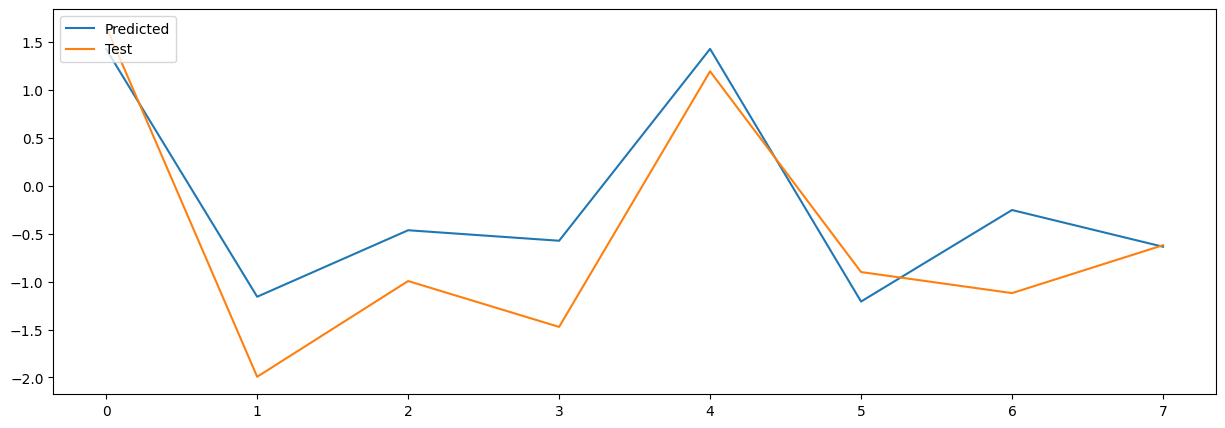

In [77]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(y_pred, label='Predicted')
ax.plot(df_test[target].values, label='Test')
plt.legend(loc='upper left')
plt.show()